In [1]:
import datacube
dc = datacube.Datacube(app='Sentinel_2')

lat, lon = 9.6, 28.43
buffer = 0.005
query = {
    'time': ('2020-10-1', '2020-10-10'),
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'output_crs': 'epsg:32635',
    'resolution': (-10, 10)
}

In [4]:
# TODO: fill cloudy pixels with 0
#from utils.deafrica_datahandling import load_ard
bands = ['blue', 'green', 'red', 'SCL']
ds = dc.load(product='s2_l2a',
             measurements=bands,
             dask_chunks={},
             **query)
ds

<xarray.Dataset>
Dimensions:      (time: 3, x: 111, y: 112)
Coordinates:
  * time         (time) datetime64[ns] 2020-10-02T08:37:47 ... 2020-10-10T08:...
  * y            (y) float64 1.062e+06 1.062e+06 ... 1.061e+06 1.061e+06
  * x            (x) float64 6.564e+05 6.564e+05 ... 6.575e+05 6.575e+05
    spatial_ref  int32 32635
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 112, 111), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 112, 111), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 112, 111), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 112, 111), meta=np.ndarray>
Attributes:
    crs:           epsg:32635
    grid_mapping:  spatial_ref

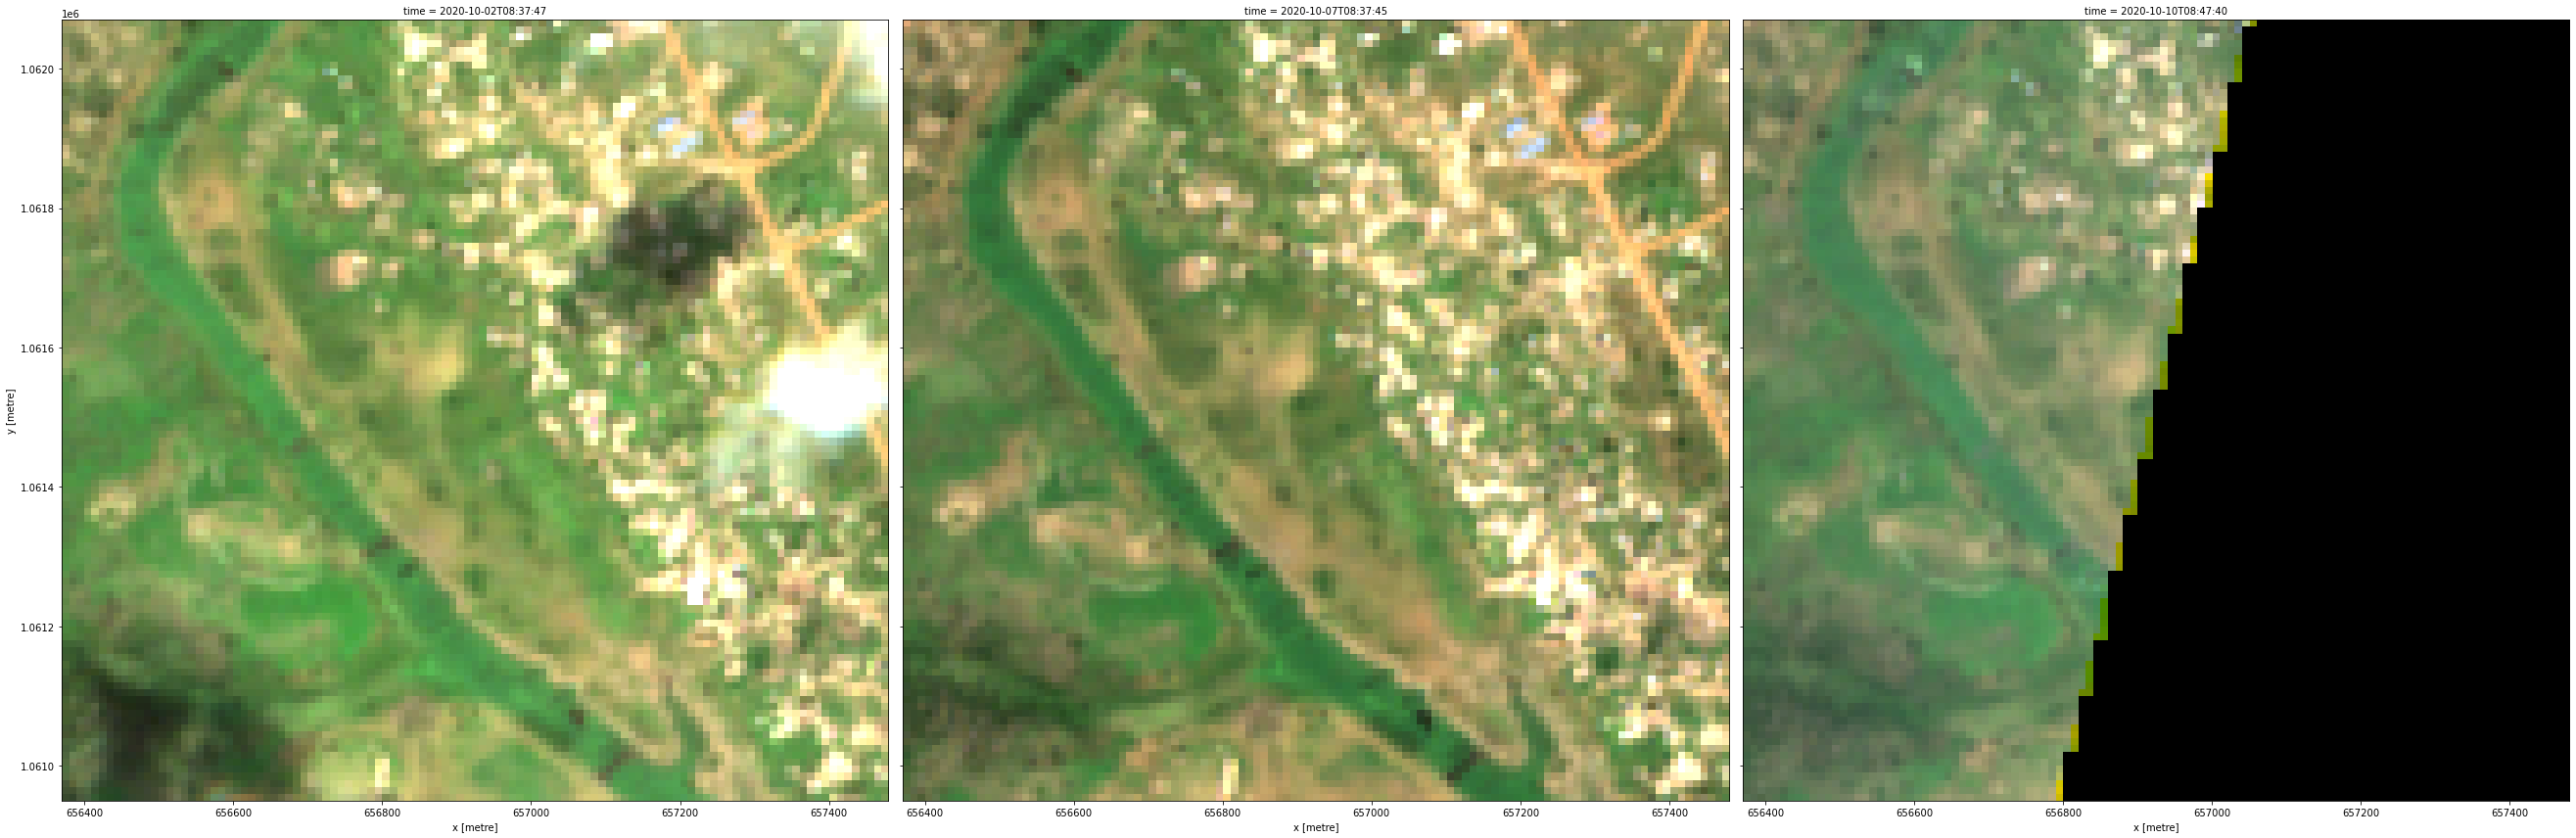

In [10]:
from utils.deafrica_plotting import rgb
rgb(ds, col='time', size=12)

In [46]:
from xarray import Dataset, DataArray, merge
import numpy as np

def create_s2_mosaic(da_in: DataArray) -> Dataset:
    """ Creates a most-recent-to-oldest mosaic of the input dataset.
    dataset_in: A dataset retrieved from the Data Cube; should contain:
        coordinates: time, latitude, longitude
        variables: variables to be mosaicked (e.g. red, green, and blue bands) """
    da_in = da_in.copy(deep=True)
    da_out = da_in.isel(time=-1).drop('time').copy(deep=True)
    out_array = da_out.values
    cols, rows = da_out.sizes['x'], da_out.sizes['y']
    latest_time = da_in.time[-1].values.astype('datetime64[D]').astype('uint16')
    recentness_matrix = np.empty((rows, cols), dtype=np.uint16)
    recentness_matrix[:] = latest_time

    for index in range(len(da_in.time) - 2, -1, -1):
        da_slice = da_in.isel(time=index).drop('time')
        da_slice_time = da_in.time[index].values.astype('datetime64[D]').astype('uint16')
        recentness_matrix[out_array == 0] = da_slice_time
        out_array[out_array == 0] = da_slice.values[out_array == 0]

    da_out.values = out_array
    recentness_data = da_out.copy(deep=True).rename(f"{da_out.name}_recentness")
    recentness_data.values = recentness_matrix
    return merge([da_out, recentness_data])

In [49]:
r = ds.red
m = create_s2_mosaic(r)
m


<xarray.Dataset>
Dimensions:         (x: 111, y: 112)
Coordinates:
  * y               (y) float64 1.062e+06 1.062e+06 ... 1.061e+06 1.061e+06
  * x               (x) float64 6.564e+05 6.564e+05 ... 6.575e+05 6.575e+05
    spatial_ref     int32 32635
Data variables:
    red             (y, x) uint16 1294 1050 1017 1076 1142 ... 955 918 692 584
    red_recentness  (y, x) uint16 18545 18545 18545 18545 ... 18542 18542 18542